In [1]:
import numpy as np
import raptoranalysis
from raptoranalysis.parser.raptorreader import RaptorReader
from raptoranalysis.parser.lammpsreader import LammpsReader
import matplotlib.pyplot as plt


Please download the example tarball `example_single_files` including the trajectory and evb output to the current directory from the following link:
https://drive.google.com/file/d/1k-Toxs7MUo35jt4fTln9TdeVunxM5OWV/view?usp=sharing

Then extract the tarball to the current directory for the following analysis.

In [2]:
# define the path of the input files
trj_file = "./prod.lammpstrj"
raptor_output_file = "./prod.evb.out"

### Read RAPTOR output
Let's read the RAPTOR output with `RaptorReader` class and see what we have.

Note: Due to the size of the file, it may take a while (from seconds to a few minutes) to load.

In this example, it takes ~ 2.5 seconds to initialize a `RaptorReader` class for a 24 MB RAPTOR output file with 10k frames.

In [3]:
raptor_reader = RaptorReader(raptor_output_file, outputfreq=10) # ignore the frames that are there due to proton hopping but not meet output frequency

Initialized RaptorReader class for file ./prod.evb.out...
n_complexes:  1 , n_frames:  10001 , has_center_location:  True , has_n_states:  True , has_states_info:  True , has_energy:  False , has_decomposed_energy:  False


In [4]:
n_frames = len(raptor_reader)
n_complexes = raptor_reader.n_complexes
timesteps = []
cec_coordinates = [[] for _ in range(n_complexes)]
pivot_ids = [[] for _ in range(n_complexes)]
evb_eigen_list = [[] for _ in range(n_complexes)]
for frame in raptor_reader:
    timesteps.append(frame.timestep)
    for i in range(n_complexes):
        cec_coordinates[i].append(frame.cec_coordinates[i])
        evb_eigen_list[i].append(frame.eigen_vectors[i])
        pivot_ids[i].append(frame.pivot_ids[i])
cec_coordinates = np.array(cec_coordinates, dtype=np.float64).reshape(n_complexes,n_frames,3)
timesteps = np.array(timesteps, dtype=int)
pivot_ids = np.array(pivot_ids, dtype=int).reshape(n_complexes,n_frames)


### Proton hopping


Calculate the proton hopping events index from the pivot ids.
In paper (J. Phys. Chem. B, Vol. 112, No. 2, 2008), equation 15 and 16 define the so-called "forward hopping" accumulation function as follows:

$$
h(\delta t) = h(\delta t - 1) + \delta h(\delta t) \text{, where } h(0) = 0
$$

$\delta h(\delta t) = 0$ , if no proton hop; $\delta h(\delta t) = 1 $ , if proton hops to a new acceptor; $\delta h(\delta t) = -1$, if proton hops back to the previous donor


As complement to the above definition by paper (J. Chem. Phys. 154, 194506 (2021); doi: 10.1063/5.0040758), a more detailed definition of the proton forward hopping index is given as follows: 
If the proton hops from water A → B → C, the index is changed from 0 → 1 → 2. Conversely, if the proton hopped from water C back to B, the index would be changed back to 1. If the proton subsequently hopped from B to a new water D, the index is updated to 2, since waters C and D are at the same level of displacement from the initial water A.

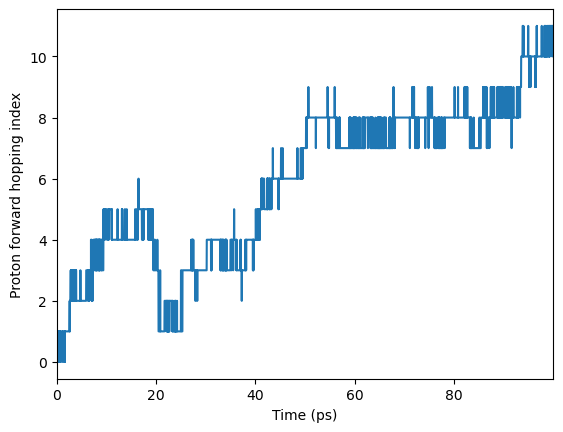

In [5]:
from raptoranalysis.analysis.protonhopping import proton_hopping_indexes
hopping_indexes = proton_hopping_indexes(pivot_ids)

plt.plot(timesteps[:10000]/1000, hopping_indexes[0,:10000])
plt.xlabel("Time (ps)")
plt.ylabel("Proton forward hopping index")
plt.xlim(0,timesteps[9999]/1000)
plt.show()


### Correlation functions of proton identity

**1. proton identity**
$$
c(t) = \frac{\langle h(t)h(0) \rangle}{\langle h \rangle}
$$
where $h(t)$ is 1 if it is equal to $h(0)$ and 0 if it is not. 

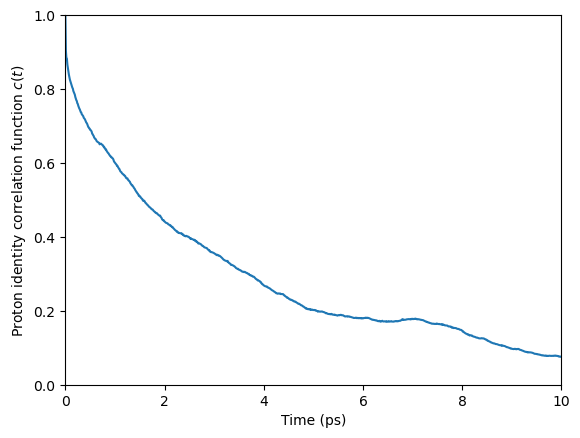

In [6]:
from raptoranalysis.analysis.protonhopping import proton_identity_correlation
taus, timeseries, _ = proton_identity_correlation(pivot_ids[0,:], 1000)
plt.plot(np.array(taus)/100, timeseries)
plt.xlabel("Time (ps)")
plt.ylabel("Proton identity correlation function $c(t)$")
plt.xlim(0,taus[-1]/100)
plt.ylim(0,1)
plt.show()

**2. The continuous correlation function**

$$
C(t) = \frac{\langle H(t)H(0) \rangle}{\langle H \rangle}
$$
where $H(t)$ is 1 as long as the hydronium-like identity has not changed from that of $H(0)$ and 0 once it has changed.

It is also possible to filter the identity indexes using the argument `intermittency`. See more about filtering in the paper *J. Chem. Phys. 154, 194506 (2021)*

Because the implementation is not fine-tuned, it may take a while (tens of minutes) to calculate the correlation functions with a large number of frames. In current test, the 10k frames takes ~ 10 minutes to calculate the correlation functions without filtering.

No filtering
Filtering


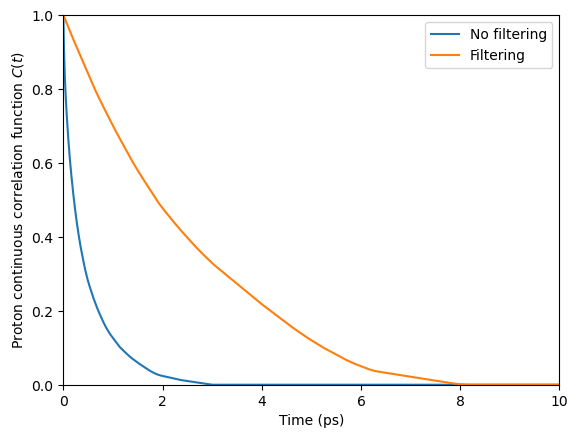

In [8]:
from raptoranalysis.analysis.protonhopping import proton_continuous_correlation
print("No filtering")
taus_con_nf, timeseries_con_nf, _ = proton_continuous_correlation(pivot_ids[0,:], 1000)
print("Filtering")
taus_con_f, timeseries_con_f, _ = proton_continuous_correlation(pivot_ids[0,:], 1000,intermittency=50) # 500fs
plt.plot(np.array(taus_con_nf)/100, timeseries_con_nf, label="No filtering")
plt.plot(np.array(taus_con_f)/100, timeseries_con_f, label="Filtering")
plt.xlabel("Time (ps)")
plt.ylabel("Proton continuous correlation function $C(t)$")
plt.xlim(0,taus_con_nf[-1]/100)
plt.ylim(0,1)
plt.legend()
plt.show()

### MS-EVB amplitude distributions

The probability distributions of (a) the largest ($c_1^2$) and the second largest ($c_2^2$) MS-EVB amplitudes,

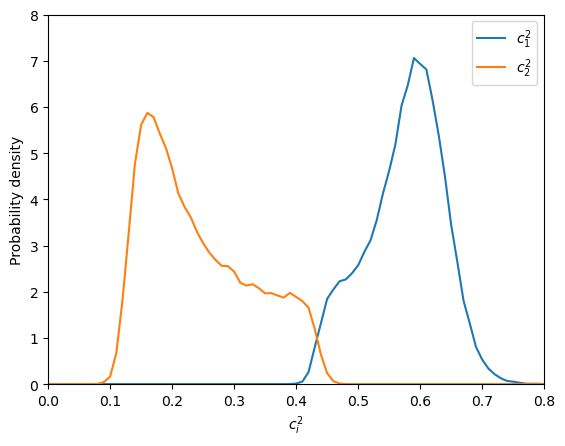

In [11]:
from raptoranalysis.analysis.evbampdist import evb_amplitude_distribution
evb_amplitudes,bin_edges = evb_amplitude_distribution(evb_eigen_list,n_bins=100)
plt.plot(bin_edges[:-1], evb_amplitudes[0,0,:],label="$c_1^2$")
plt.plot(bin_edges[:-1], evb_amplitudes[0,1,:],label="$c_2^2$")
plt.legend()
plt.xlabel("$c_i^2$")
plt.ylabel("Probability density")
plt.xlim(0,0.8)
plt.ylim(0,8)
plt.show()

**Free energy as a function of $c_1^2$**
$$
F(c_1^2) = -k_{B}T \ln P(c_1^2)
$$

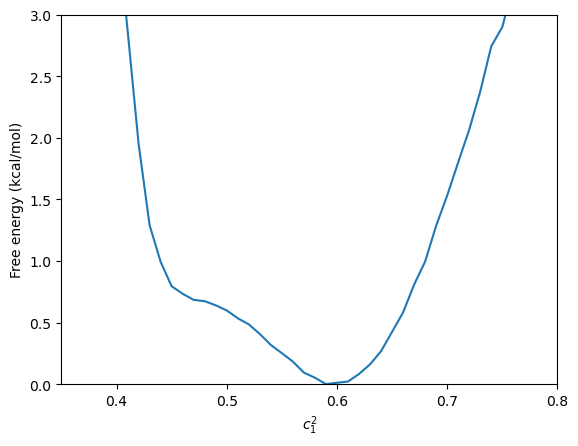

In [12]:

KBT=0.0019872041*298.15
free_energies = -KBT*np.log(evb_amplitudes[0,0,:]+1e-10)
free_energies -= np.min(free_energies)
plt.plot(bin_edges[:-1], free_energies)
plt.xlabel("$c_1^2$")
plt.ylabel("Free energy (kcal/mol)")
plt.xlim(0.35,0.8)
plt.ylim(0,3)
plt.show()

**Free energy profiles of proton transfer as a function of the difference between two largest EVB weights**

the barriers is 0.7749077140287928


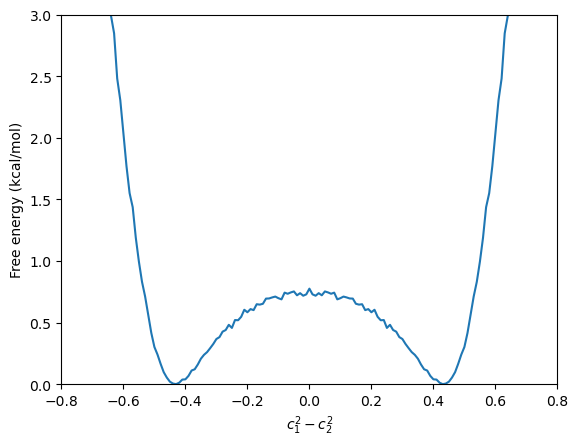

In [14]:
from raptoranalysis.analysis.evbampdist import evb_amp_difference
evb_difference,bin_edges2 = evb_amp_difference(evb_eigen_list,n_bins=100)
KBT=0.0019872041*298.15
free_energies = -KBT*np.log(evb_difference[0,:]+1e-10)
free_energies -= np.min(free_energies)
print(f"the barriers is {free_energies[0]}")
# 
free_energies = np.array([list(reversed(free_energies)),free_energies]).flatten()
bin_edges2 = np.array([list(reversed(-bin_edges2)),bin_edges2]).flatten()
plt.plot(bin_edges2[1:-1], free_energies)
plt.xlabel("$c_1^2 - c_2^2$")
plt.ylabel("Free energy (kcal/mol)")
plt.xlim(-0.8,0.8)
plt.ylim(0,3)
plt.show()

### MSD
The MSD (mean squared displacement) is a measure of the displacement of a particle over a given time interval. It is defined as:
$$
{\text{MSD}}(t) = \langle \left| \mathbf{r}(t + \tau) - \mathbf{r}(t) \right|^2 \rangle
$$

In [15]:
box_boundary=np.array([19.3887, 19.3887, 19.3887])
for cec_coordinate in cec_coordinates:
    for i in range(1, cec_coordinate.shape[0]):
        # if the distance between two frames is larger than half of the box boundary, then the cec has moved to the other side of the box
        cec_coordinate[i] = cec_coordinate[i-1] + (cec_coordinate[i] - cec_coordinate[i-1] + box_boundary/2) % box_boundary - box_boundary/2



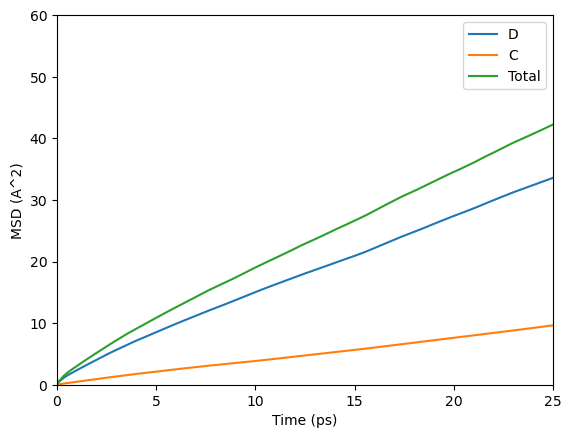

In [16]:
from raptoranalysis.analysis.cecmsd import calc_cec_msd
msd_d, msd_c, msd = calc_cec_msd(cec_coordinates, pivot_ids)

plt.plot(timesteps/1000, msd_d[0,:,-1], label="D") # the MSD comes from proton hopping
plt.plot(timesteps/1000, msd_c[0,:,-1], label="C") # the MSD comes from continuous diffusion
plt.plot(timesteps/1000, msd[0,:,-1], label="Total") # the total MSD
plt.xlim(0,25)
plt.ylim(0,60)
plt.xlabel("Time (ps)")
plt.ylabel("MSD (A^2)")
plt.legend()
plt.show()

### RDF
Let's try to calculate RDF between CEC and water oxygen atoms.

For calculation of RDF, we need to define two groups of atoms. The `RaptorRdf` class always assumes that group1 is CEC, reading from raptor output, and group2 is some other atoms read from lammps dump files. Therefore, you need to give RAPTOR output file and lammps dump files as input to `RaptorRdf` class.

The argument `group1` is a list of the complex indexes of CEC atoms in the RAPTOR output file that you are interested in. The argument `group2` is a list of the atom ids of the interested atoms in the lammps dump file. Due to the fact that the atom types of oxygen atoms can change in the simulation (e.g. water oxygen atoms can be converted to hydronium oxygen atoms, and vice verse), we also provide another argument `group2_type` to specify a list of the atom types of the interested atoms. In this example, we are interested in water oxygen atoms, which have atom type 1 in the lammps dump file. Therefore, we set `group2_type=1`.

Note that you can only give either `group2` or `group2_type`, and leave the other one blank, otherwise the code will raise an error.

Besides, we also need to specify the bin size or the number of bins for RDF calculation. In this example, we set `n_bins=80`, `r_max=8.0` to calculate RDF from 0 to 8 Angstrom with 80 bins, resulting in a bin size of 0.1 Angstrom.

If you want to calculate RDF between normal atoms, not CEC, then just use any other md analysis tools, such as `MDAnalysis` or `MDTraj`.

In [17]:
from raptoranalysis.analysis.rdf import RaptorRdf
rdf_calculator = RaptorRdf(raptor_output_file, trj_file, group1 = None, group2_types=[1], n_bins = 80, max_r = 8, output_freq = 10)
rdf_calculator.calculate()
rdf = rdf_calculator.rdf
r = rdf_calculator.bin_centers


Initialized RaptorReader class for file ./prod.evb.out...
n_complexes:  1 , n_frames:  100001 , has_center_location:  True , has_n_states:  True , has_states_info:  True , has_energy:  False , has_decomposed_energy:  False
Initializing LammpsReader class for file ./prod.lammpstrj...
Calculating rdf...


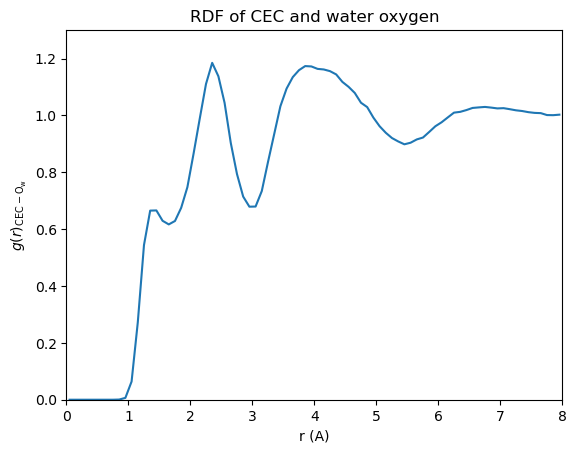

In [18]:
plt.plot(r, rdf)
plt.xlabel("r (A)")
plt.ylabel("$g(r)_\mathrm{CEC-O_w}$")
plt.title("RDF of CEC and water oxygen")
plt.xlim(0,8)
plt.ylim(0,1.3)
plt.show()